In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import ssl
import pandas as pd
import pymc3 as pm 
import numpy as np
import arviz as az

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

from scipy.stats import percentileofscore
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

import scipy

In [3]:
housing = fetch_california_housing()

In [4]:
scaler = StandardScaler()
housing.data = scaler.fit_transform(housing.data)

In [5]:
df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df_target = pd.DataFrame(data=housing.target, columns=['MedHouseVal'])

In [6]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2, random_state=42)

In [8]:
X_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,-0.321654,0.346478,-0.166259,-0.190451,0.772251,0.059808,-1.367976,1.267645
8267,-0.030620,1.617807,-0.386181,-0.117472,-0.098440,-0.128306,-0.871699,0.703627
17445,0.150349,-1.957806,0.087641,-0.235400,-0.450778,-0.033453,-0.455012,-0.454356
14265,-1.014947,0.584852,-0.576442,-0.132670,-0.006602,0.088940,-1.377340,1.227714
2271,-0.166583,1.141059,0.339282,0.079205,-0.486983,-0.074203,0.537543,-0.114948
...,...,...,...,...,...,...,...,...
11284,1.315592,0.505394,0.282943,-0.359587,-0.677723,-0.003697,-0.867017,0.803453
11964,-0.431983,0.346478,0.581864,0.364661,0.289220,0.080261,-0.754652,1.067992
5390,-0.492832,0.584852,-0.582949,-0.035828,0.291870,0.025170,-0.749970,0.593818
860,0.973025,-1.083767,0.390584,-0.060554,0.310414,0.010422,0.912092,-1.193070


### Compare with other ML models: Linear regression and Random Forest

In [12]:
def evaluate(X_train, X_test, y_train, y_test):
    model_name_list = ['Linear Regression', 'Random Forest']
    
    model_lr = LinearRegression()
    model_rf = RandomForestRegressor(n_estimators=282, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=50, bootstrap=False )  # n_estimator == number of trees has been chosen randomly 
    
    results = pd.DataFrame(columns=['mae', 'rmse'], index=model_name_list)

    for i, model in enumerate([model_lr, model_rf]):
        # y_train is now column vectore thus should be changed to row vecotor by using .values.ravel()
        model.fit(X_train, y_train.values.ravel())
        predictions = model.predict(X_test)
        
        mae = np.mean(abs(predictions-y_test.values.ravel()))
        rmse = np.sqrt(np.mean((predictions-y_test.values.ravel())**2))
        
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]

    return results

In [13]:
results = evaluate(X_train, X_test, y_train, y_test)

In [14]:
results

,mae,rmse
Linear Regression,0.5332,0.745581
Random Forest,0.312006,0.483414


In [301]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.575787706032451

### Implementing Bayesian LR

In [302]:
formula = 'MedHouseVal ~ MedInc + HouseAge + AveRooms + \
                         AveBedrms + Population + AveOccup + \
                         Latitude + Longitude'

In [303]:
X_train = pd.concat([y_train, X_train], axis=1)
X_test  = pd.concat([y_test,  X_test], axis=1)

In [304]:
with pm.Model() as linear_model:
    
    priors = pm.glm.families.Normal()
    
    pm.GLM.from_formula('MedHouseVal ~ MedInc + HouseAge + AveRooms + \
                                       AveBedrms + Population + AveOccup + \
                                       Latitude + Longitude',
                        data=X_train,
                        family=priors
                       )
    
    linear_model = pm.sample(draws=2000, chains = 2, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Longitude, Latitude, AveOccup, Population, AveBedrms, AveRooms, HouseAge, MedInc, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 40 seconds.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


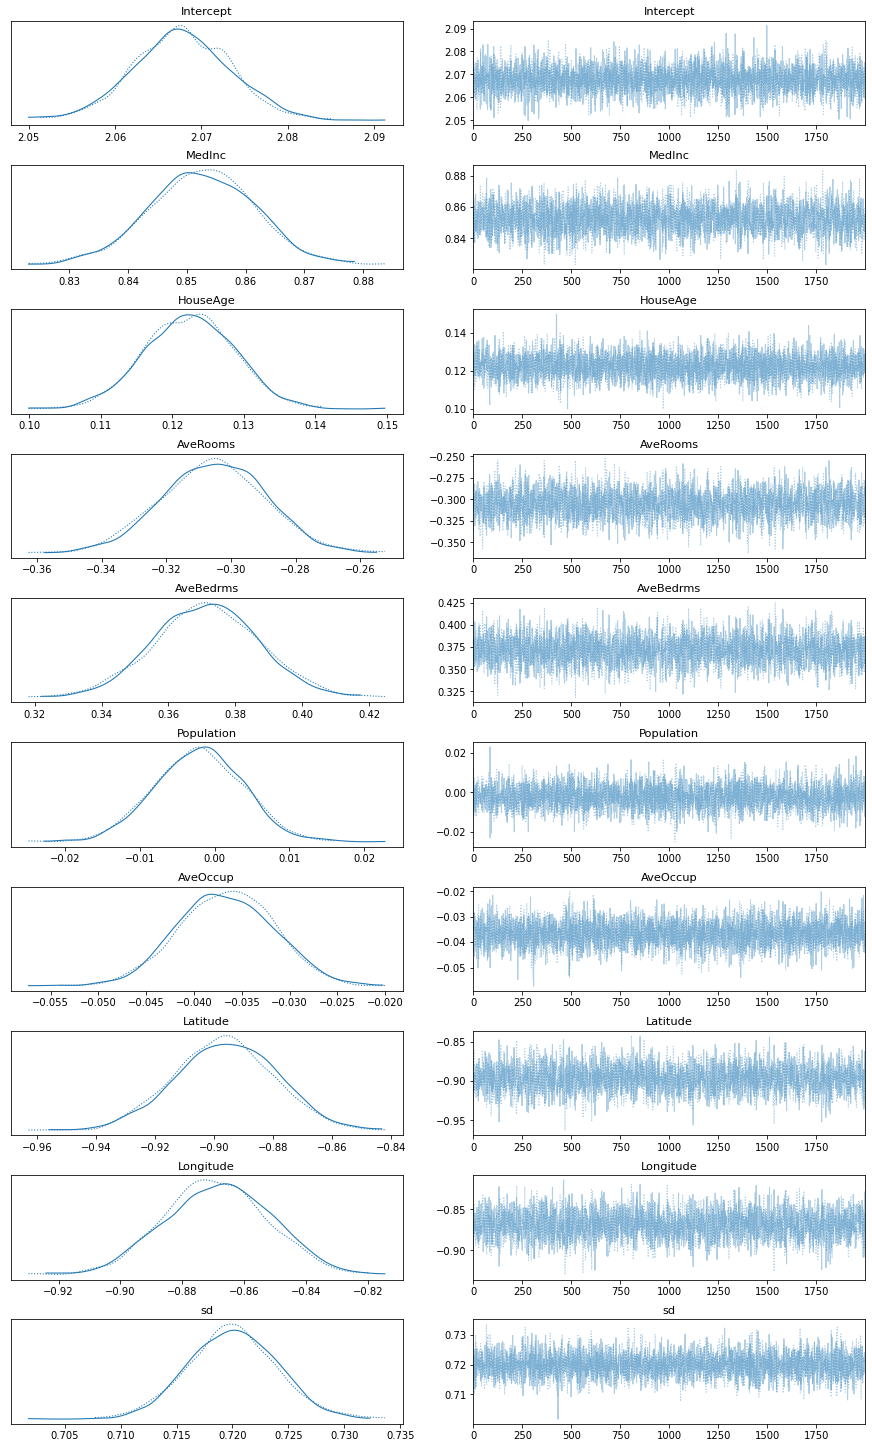

In [305]:
pm.traceplot(linear_model);

In [306]:
pm.summary(linear_model)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,2.068,0.006,2.057,2.079,0.0,0.0,4777.0,4777.0,4788.0,2823.0,1.0
MedInc,0.853,0.009,0.836,0.870,0.0,0.0,2864.0,2864.0,2837.0,2910.0,1.0
HouseAge,0.122,0.006,0.111,0.134,0.0,0.0,4488.0,4488.0,4500.0,3283.0,1.0
AveRooms,-0.305,0.016,-0.336,-0.277,0.0,0.0,2622.0,2621.0,2622.0,2827.0,1.0
AveBedrms,0.371,0.016,0.341,0.400,0.0,0.0,2774.0,2773.0,2776.0,2861.0,1.0
Population,-0.002,0.006,-0.013,0.008,0.0,0.0,4371.0,2685.0,4367.0,3408.0,1.0
AveOccup,-0.037,0.005,-0.046,-0.028,0.0,0.0,3959.0,3844.0,3974.0,2669.0,1.0
Latitude,-0.896,0.017,-0.929,-0.866,0.0,0.0,2602.0,2600.0,2607.0,2678.0,1.0
Longitude,-0.869,0.017,-0.899,-0.837,0.0,0.0,2645.0,2645.0,2648.0,2567.0,1.0
sd,0.720,0.004,0.713,0.728,0.0,0.0,4267.0,4263.0,4291.0,2619.0,1.0


In [307]:
X_train

,MedHouseVal,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,1.030,-0.321654,0.346478,-0.166259,-0.190451,0.772251,0.059808,-1.367976,1.267645
8267,3.821,-0.030620,1.617807,-0.386181,-0.117472,-0.098440,-0.128306,-0.871699,0.703627
17445,1.726,0.150349,-1.957806,0.087641,-0.235400,-0.450778,-0.033453,-0.455012,-0.454356
14265,0.934,-1.014947,0.584852,-0.576442,-0.132670,-0.006602,0.088940,-1.377340,1.227714
2271,0.965,-0.166583,1.141059,0.339282,0.079205,-0.486983,-0.074203,0.537543,-0.114948
...,...,...,...,...,...,...,...,...,...
11284,2.292,1.315592,0.505394,0.282943,-0.359587,-0.677723,-0.003697,-0.867017,0.803453
11964,0.978,-0.431983,0.346478,0.581864,0.364661,0.289220,0.080261,-0.754652,1.067992
5390,2.221,-0.492832,0.584852,-0.582949,-0.035828,0.291870,0.025170,-0.749970,0.593818
860,2.835,0.973025,-1.083767,0.390584,-0.060554,0.310414,0.010422,0.912092,-1.193070


In [308]:
X_test

,MedHouseVal,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20046,0.47700,-1.152489,-0.289187,-0.499896,-0.156976,-0.029562,0.077681,0.200449,0.279366
3024,0.45800,-0.705015,0.108104,-0.157477,0.204301,0.123206,-0.037634,-0.230283,0.054757
15663,5.00001,-0.205588,1.856182,-0.586814,0.188231,-0.101972,-0.164679,1.015093,-1.432653
20484,2.18600,0.982710,-0.924851,0.296929,-0.161370,0.246834,0.035990,-0.632923,0.424114
9814,2.78000,-0.076678,0.425936,0.025864,-0.144836,-0.320086,-0.056520,0.462633,-1.178096
...,...,...,...,...,...,...,...,...,...
15362,2.63300,0.386535,-1.004309,0.635869,-0.063945,-0.065767,-0.007868,-1.063655,1.172810
16623,2.66800,-0.602214,-0.050812,0.284108,0.337756,0.198266,-0.070310,-0.127282,-0.629052
18086,5.00001,2.820927,-0.289187,0.731040,-0.315451,0.140868,-0.026976,0.785682,-1.237992
2144,0.72300,-0.571473,0.584852,-0.056574,-0.239614,-0.175266,-0.046414,0.532861,-0.094982


### Evaluate Bayesian Model Using Mean of Model Parameters

In [309]:
def evaluate_trace(trace, X_test, y_test, model_results):
    
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    var_weights = pd.DataFrame(var_dict)
    
    var_means = var_weights.mean(axis=0)
    
    X_test['Intercept'] = 1
    
    names = X_test.columns[1:]
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    results = pd.DataFrame(index = X_test.index, columns=['estimate'])
    
    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
    
    actual = np.array(y_test)
    errors = results['estimate'] - actual.ravel()
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print("mae", mae)
    print("rmse", rmse)
    
    model_results.loc['Bayesian LR', :] = [mae, rmse]
    
    return model_results

In [310]:
all_model_results = evaluate_trace(linear_model,X_test, y_test, results)

mae 0.5331631251829723
rmse 0.7455982318032794


In [311]:
all_model_results

,mae,rmse
Linear Regression,0.5332,0.745581
Random Forest,0.330294,0.505997
Bayesian LR,0.533163,0.745598


In [312]:
def test_model(trace, test_observation):
    
    # Print out the test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['MedHouseVal']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('MedHouseVal')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the actual grade
    plt.vlines(x = actual, ymin = 0, ymax = 5, 
               linestyles = '--', colors = 'red',
               label = 'True MedHouseVal',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('MedHouseVal'); plt.ylabel('Density');
    
    # Prediction information
    print('True MedHouseVal = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

Test Observation:
MedHouseVal    1.982000
MedInc         0.638617
HouseAge       0.584852
AveRooms       0.320406
AveBedrms     -0.003487
Population    -0.667126
AveOccup      -0.003753
Latitude      -0.815516
Longitude      0.773505
Intercept      1.000000
Name: 7113, dtype: float64
True MedHouseVal = 1
Average Estimate = 2.6451
5% Estimate = 1.4770    95% Estimate = 3.7741


<ipython-input-312-7564dd1fddf1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_observation['Intercept'] = 1
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


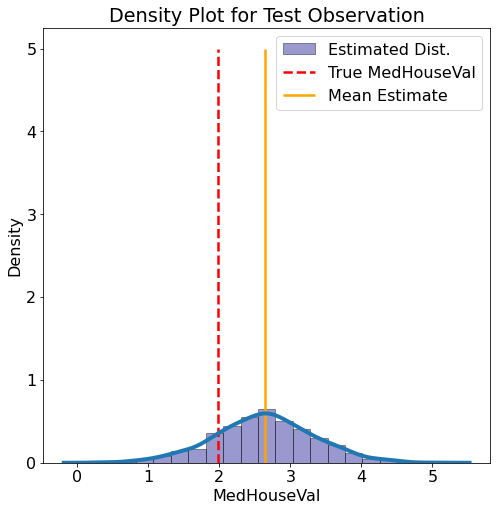

In [318]:
test_model(linear_model, X_test.iloc[6])

In [319]:
def model_effect(query_var, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    # Linear Model that estimates a grade based on the value of the query variable 
    # and one sample from the trace
    def lm(value, sample):
        
        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        
        return prediction
    
    figsize(6, 6)
    
    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel('MedHouseVal', size = 16)
    plt.title("Posterior of MedHouseVal vs %s" % query_var, size = 18)
    plt.show()

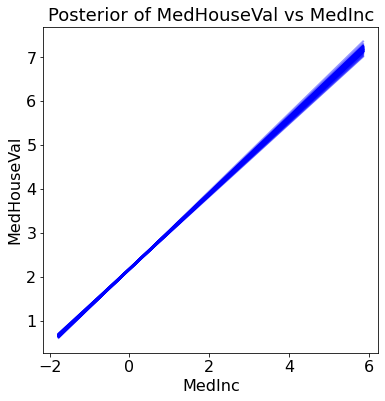

In [320]:
model_effect('MedInc', linear_model, X_train.drop(columns='MedHouseVal'))